In [1]:
import numpy as np
import pandas as pd
import spiceypy as spice
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.constants import c
from astropy.time import Time
from astroquery.jplhorizons import Horizons
import rebound
import random

In [2]:
def LT(t, obsxyz, func):
    """
    Calculates the light time correction to the position vector of an object
    
    Arguments:
    
    t: days
    
    Julian date of observation
    
    obsxyz: np.array
    
    Position vector of observer with respect to the Solar System barycenter.
    
    func: function
    
    A get_target_xyz like function that returns the position and velocity vector of a body at a certain time
    
    Returns:
    
    txyz: np.array
    
    A corrected position vector of the observed object
    
    """
    
    txyz = func(t)
    dist = np.linalg.norm(txyz[0]-obsxyz)
    ltime = float(((dist*u.AU).to(u.m)/c)/u.s)
    d = 10
    while(abs(d)>1e-16):
        txyz = func(t-ltime)
        dist = np.linalg.norm(txyz[0]-obsxyz)
        ltime2 = float(((dist*u.AU).to(u.m)/c)/u.s)
        d = (ltime2-ltime)/ltime
        ltime = ltime2
    return txyz

In [3]:
def Furnisher(k):
    '''
    This function is used to load all kernels needed in an operation.
    Comment out kernels not in use and add the ones in use.
    
    Arguments: NA
    Returns: NA
    
    '''
    spice.kclear()
    spice.furnsh('/Users/user/Downloads/naif0008.tls.txt')
    if k == '310+341+435':
            spice.furnsh('/Users/user/Downloads/jup310.bsp')
            spice.furnsh('/Users/user/Downloads/jup341.bsp')
            spice.furnsh('/Users/user/Downloads/de435.bsp')
    elif k == '310+341':
            spice.furnsh('/Users/user/Downloads/jup310.bsp')
            spice.furnsh('/Users/user/Downloads/jup341.bsp')
    elif k == '310+435':
            spice.furnsh('/Users/user/Downloads/de435.bsp')
            spice.furnsh('/Users/user/Downloads/jup310.bsp')
    elif k == '341+435':
            spice.furnsh('/Users/user/Downloads/jup341.bsp')
            spice.furnsh('/Users/user/Downloads/de435.bsp')
    elif k == '310':
            spice.furnsh('/Users/user/Downloads/jup310.bsp')
    elif k == '341':
            spice.furnsh('/Users/user/Downloads/jup341.bsp')
    elif k == '435':
            spice.furnsh('/Users/user/Downloads/de435.bsp')
    pass

In [4]:
def get_spice_function(name,cor,loc):
    """
    This wrapper function automates the creation of objects through the JPL Horizons database. 
    
    Arguments:
    
    name: str
    
    Stipulates the target object in Horizons. The major bodies in the Solar System have an id based on their position.
    Hence '5' refers to Jupiter and '3' to Earth. A single number designator refers to a barycenter and a designator
    such as '599' to the planetary center. For minor bodies in the Solar System, the id_type in the Horizons
    must be changed to "minorbody"
    
    cor: str
    
    Refers to the type of correction that the object has. Available arguments are 'NONE', 'LT','LT+S'
    
    loc: str
    
    Designates the location of observation. Names that start with "g@#" refer to barycenters where the number designates the 
    body that the observer is based at. Hence "g@0" refers to the Solar System barycenter. Also takes Earth location designators.
    Observatories are named after their code. Hence, Pan-Starrs observatory is referred as "f51"

    Returns:
    
    get_target_xyz function
    """    
    def get_target_xyz(t):
        """
        Returns the vectors of the Horizons body at a certain time t.
        
        Arguments:
        
        t: days
        
        Julian date of observation
        
        Returns:
    
        xyz: numpy array
        
        A position vector of the observed object
    
        uvw: numpy array
        
        An instantaneous velocity vector of the observed object
        
        radec: numpy array
        
        The right ascension and declination of the observed object
        """
        
        state,lighttime = spice.spkezr(name,t,'J2000',cor,loc)
        pos,lighttime = spice.spkpos(name,t,'J2000',cor,loc)
        range,ra,dec = spice.recrad(pos) 
        xyz = np.array([state[0],state[1],state[2]])/149597870.7#6.68459e-9
        uvw = np.array([state[3],state[4],state[5]])/149597870.7*24.*3600.#*6.68459e-9
        radec = np.array([ra,dec])
        return xyz,uvw,radec*180/np.pi
    return get_target_xyz



In [5]:
# From 432 (km^3/s^2)
GMEarth = 398600.435420
GMMoon = 27068703.151194

GMMercuryB = 22031.780000
GMVenusB = 324858.592000
GMEarthB = 403503.235502
GMMarsB = 42828.375214
GMJupiterB = 126712764.133446
GMSaturnB = 37940585.200000
GMUranusB = 5794556.465752
GMNeptuneB = 6836527.100580
GMSun = 132712440041.939400 # Just Sun
GMSunterr = GMSun + GMMercuryB + GMVenusB + GMEarthB + GMMarsB

# From 310

GMJupiter = 1.266865341960128E+08
GMIo = 5.959924010272514E+03
GMEuropa = 3.202739815114734E+03
GMGanymede = 9.887819980080976E+03
GMCallisto = 7.179304867611079E+03
GMAmalthea = 1.487604677404272E-01
GM10310 = 1.327132332639000E+11

GMSaturnB310 = 3.794058500000000E+07
GMUranusB310 = 5.794548600000000E+06
GMNeptuneB310 = 6.836527100580000E+06
GMJupiterB310 = 1.267127641334463E+08

In [6]:
MMercuryB = GMMercuryB/GMSun
MVenusB = GMVenusB/GMSun
MEarthB = GMEarthB/GMSun
MEarth = GMEarth/GMSun
MMoon = GMMoon/GMSun
MMarsB = GMMarsB/GMSun
MJupiter = (GMJupiterB-GMIo-GMEuropa-GMGanymede-GMCallisto)/GMSun
MSaturnB = GMSaturnB/GMSun
MUranusB = GMUranusB/GMSun
MNeptuneB = GMNeptuneB/GMSun
MIo = GMIo/GMSun
MEuropa = GMEuropa/GMSun
MGanymede = GMGanymede/GMSun
MCallisto = GMCallisto/GMSun
MAmalthea = GMAmalthea/GMSun

In [7]:
Furnisher("310+341+435")

In [8]:
def get_astroquery_function(name,cor,loc):
    """
    This wrapper function automates the creation of objects through the JPL Horizons database. 
    
    Arguments:
    
    name: str
    
    Stipulates the target object in Horizons. The major bodies in the Solar System have an id based on their position.
    Hence '5' refers to Jupiter and '3' to Earth. A single number designator refers to a barycenter and a designator
    such as '599' to the planetary center. For minor bodies in the Solar System, the id_type in the Horizons
    must be changed to "minorbody"
    
    cor: str
    
    Refers to the type of correction that the object has. Available arguments are "geometric","astrometric" and 
    "apparent"
    
    loc: str
    
    Designates the location of observation. Names that start with "g@#" refer to barycenters where the number designates the 
    body that the observer is based at. Hence "g@0" refers to the Solar System barycenter. Also takes Earth location designators.
    Observatories are named after their code. Hence, Pan-Starrs observatory is referred as "f51"

    Returns:
    
    get_target_xyz function
    """    
    def get_target_xyz(t):
        """
        Returns the vectors of the Horizons body at a certain time t.
        
        Arguments:
        
        t: days
        
        Julian date of observation
        
        Returns:
    
        xyz: numpy array
        
        A position vector of the observed object
    
        uvw: numpy array
        
        An instantaneous velocity vector of the observed object
        """
        
        obj = Horizons(id = name, location = loc, epochs = t, id_type = 'majorbody')
        obj1 = obj.vectors(aberrations = cor, refplane = 'earth')
        xyz = np.array([float(obj1['x']),float(obj1['y']),float(obj1['z'])])
        uvw = np.array([float(obj1['vx']),float(obj1['vy']),float(obj1['vz'])])
        obj2 = obj.ephemerides(refsystem = 'J2000', extra_precision = True)
        radec = np.array([float(obj2['RA']),float(obj2['DEC']),float(obj1['range'])])
        return xyz,uvw,radec
    return get_target_xyz 

In [9]:
def monthToNum(shortMonth):
    
    '''
    
    Returns the name of a month that a number corresponds to and vice versa
    
    Arguments:
    
    shortMonth: str
    
    Either the first three letters of a month or its number (e.g. 01 for January, 10 for October)
    
    Returns:
    
    shortMonth: str
    
    Either the first three letters of a month or its number (e.g. 01 for January, 10 for October),
    the other one to the one that was given as an argument
    
    '''
    
    return{
        'Jan' : '01', 'Feb' : '02','Mar' : '03','Apr' : '04','May' : '05','Jun' : '06','Jul' : '07','Aug' : '08',
        'Sep' : '09', 'Oct' : '10','Nov' : '11','Dec' : '12','01' : 'Jan','02' : 'Feb','03' : 'Mar','04' : 'Apr',
        '05' : 'May','06' : 'Jun','07' : 'Jul','08' : 'Aug','09' : 'Sep', '10' : 'Oct','11' : 'Nov','12' : 'Dec'}[shortMonth]

In [10]:
def JD_to_SpiceJD(jd):
    '''
    
    Converts jd date to spice units of time.
    
    Arguments:
    
    jd: float
    
    A jd time in days
    
    Returns:
    
    newjd: float
    
    A spice usable time in seconds
    
    
    '''
    t = Time(jd, format='jd', scale='utc')
    k = t.fits
    print(k)
    year = k[0:4]
    month = k[5:7]
    day = k[8:10]
    hours = k[11:13]
    minutes = k[14:16]
    seconds = k[17:23]
    newmnth = monthToNum(month)
    utc = newmnth + ' ' + day + ", " + year
    newjd = spice.str2et(utc) + int(hours)*3600 + int(minutes)*60 + float(seconds)
    return newjd

In [11]:
def CordConv(xyz):
    '''
    This function takes in a position vector of a body relative to an observer and returns a radec.
    
    Arguments:
    
    xyz: numpy array
    
    Should be three values, the x,y,z of the position vector
    
    Returns:
    
    radec: numpy array
    
    Two values, the first for right ascension and the second for declination
    
    '''
    DEC = -(np.arccos(xyz[2]/np.linalg.norm(xyz))-np.pi/2)
    RA = (np.arctan2(xyz[1],xyz[0]))
    while (RA > 2*np.pi):
        RA -= 2*np.pi   
    while (RA < 0):
        RA += 2*np.pi   
    return np.array([RA*180/np.pi,DEC*180/np.pi])

In [12]:
def Mags(n):
    mags  = []
    for i in range(0,n):
        temp = loguniform(0.003, 1.18)
        mags.append(14.2-2.5*np.log(temp**2))   
    return mags

In [13]:
def FinderSpicef51(name,t):
    '''
    
    Finds the radec of objects in the jovian system from the pansstars observatory. Used to test the correspondence
    of spice and Horizons.
    
    Arguments:
    
    name: str
    
    The name of the object in spice documentation. See Summary_Names.txt
    
    t: float
    
    A julian date
    
    '''
    thor = Time(t, format='jd', scale='utc')
    thor = thor.tt.value
    tstr = "jd " + str(t) + " utc"
    ts = spice.str2et(tstr)
    get_earth = get_astroquery_function('0','geometric','f51')
    get_jup = get_spice_function(name,"NONE","0")
    exyz = get_earth(thor)
    jxyz = get_jup(ts)
    fxyz = LT(ts, -exyz[0], get_jup)
    vectors = fxyz[0] + exyz[0]
    return CordConv(vectors)

In [14]:
def FinderHorizonsf51(name,t):
    '''
    
    Finds the radec of objects in the jovian system from the pansstars observatory from the Horizons data base.
    
    Arguments:
    
    name: str
    
    The name of the object in spice documentation. See Summary_Names.txt
    
    t: float
    
    A julian date
    
    '''
    thor = Time(t, format='jd', scale='utc')
    thor = thor.tt.value
    get_pans = get_astroquery_function(name,'astrometric','f51')
    vecs2 = get_pans(thor)
    return CordConv(vecs2[0])

In [15]:
def FinderReboundf51(t,years,arr,times,vecs,IDs):
    '''
    
    Finds the radec of objects in the jovian system from the pansstars observatory a number of years before
    the time of observation and integrates it to the time of observation using rebound.
    
    Arguments:
    
    name: str
    
    The name of the object in spice documentation. See Summary_Names.txt
    
    t: float
    
    A julian date
    
    '''
    tstr = "jd " + str(t) + " utc"
    ts = spice.str2et(tstr)
    get_earth = get_astroquery_function('0','geometric','f51')
    sec_year = 86400*365.25
    sim = Integrator(ts - years*sec_year,ts,['1','2','3','4','6','7','8',
        'Jupiter','Io','Europa','Ganymede','Callisto'],[MMercuryB,MVenusB,
        MEarthB,MMarsB,MSaturnB,MUranusB,MNeptuneB,MJupiter,MIo,MEuropa,MGanymede,
        MCallisto],[9,10,11,12,13,14,15],GMSun,arr)
    ps = sim.particles
    radec = []
    ttemp = ts
    for j in range(0,len(times)):
        temp = "jd " + str(times[j]) + " utc"
        ttemp2 = spice.str2et(temp)
        sim.integrate(sim.t + (ttemp2-ttemp)/86400)
        ps = sim.particles
        ttemp = ttemp2
        F51 = vecs[j][0]
        for i in range(13,len(ps)):
            dist = np.sqrt((ps[i].x-ps[3].x)**2 + (ps[i].y-ps[3].y)**2 + (ps[i].z-ps[3].z)**2)
            ltime = float(((dist*u.AU).to(u.m)/c)/u.s)
            sim.integrate(sim.t - ltime/(24*3600))
            ps = sim.particles
            AnSun = np.array([float(ps[i].x),float(ps[i].y),float(ps[i].z)])
            vectors = AnSun + F51Sun[0]
            radec.append(np.array([CordConv(vectors),times[j],IDs[j]]))
            sim.integrate(sim.t + ltime/(24*3600))
            ps = sim.particles
    return radec

In [16]:
def SimStart2(t,bsolar,msolar,iJovian,Ms,arr):
    '''
    Starts the simulation. Adds all particles
    
    Arguments:
    
    bsolar: list of strs
    
    The names of the bodies added. Typically: '1','2','3','4', 'Jupiter','Io','Ananke'. 'Jupiter' must be added
    last followed by the satellites in the system
    
    msolar: list of floats
    
    The masses of the bodies in bsolar. Must be at the order of bsolar
    
    iJovian: list, int
    
    The indexes (+1) that the satellites in the solar system have in bsolar
    
    '''
    
    sim = rebound.Simulation()
    k = np.sqrt(Ms*10**9)*(1.49597870700*10**11)**(-1.5) *86400.00000
    sim.G = k**2
    sim.add(m=1.)
    for i in range(0,len(bsolar)):
        get_planet = get_spice_function(bsolar[i],'NONE','SUN')
        xyz,uvw,radec = get_planet(t)
        xyz = xyz
        #uvw = (uvw*24*3600)
        sim.add(m=msolar[i],x=xyz[0],y=xyz[1],z=xyz[2],vx=uvw[0],vy=uvw[1],vz=uvw[2])
    ps = sim.particles
    len(ps)
    for i in range(0,len(arr)):
        sim.add(a=arr[i][0],e=arr[i][1],inc=arr[i][2],Omega=arr[i][3],omega=arr[i][4],f=arr[i][5],primary=ps[bsolar.index('Jupiter')+1])  
    sim.n_active = len(bsolar)+1
    sim.move_to_com()
    return sim

In [17]:
def Integrator(t,ten,bsolar,msolar,iJovian,Ms,arr):
    '''
    Integrates the system. If body1 or body2 refer to the Jupiter Barycenter, while there are bodies in the Jovian system
    teh function will compute the barycenter in the simulation
    
    Arguments:
    
    bsolar
    msolar
    iJovian
    
    body1 and body2: name in str
    
    The spice names of the bodies that we want to look into to check the error of our integrator
    
     '''
    sim = SimStart2(t,bsolar,msolar,iJovian,Ms,arr)
    year = 365.25 # days
    tmax = (ten - t)/86400 
    sim.integrate(tmax)
    return sim

In [18]:
def Seeder(n):
    arr = []
    for i in range(0,n):
        e = random.uniform(0,1)
        a = random.uniform(0.05,(0.177/(1+e)))
        i = random.uniform(0,np.pi)
        Om = random.uniform(0,2*np.pi)
        om = random.uniform(0,2*np.pi)
        k = random.uniform(0,2*np.pi)
        arr.append(np.array([a,e,i,Om,om,k]))
    return arr

In [19]:
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
df = pd.read_excel('/Users/user/wfilter.xlsx', sheetname='Sheet1')
print("Column headings:")
print(df.columns)
IDs = np.array(df['ID'])
times = np.array(df['JDUTC'])

Column headings:
Index(['ID', 'smf-name', 'smf-filepath', 'reduction', 'JDUTC', 'RA', 'Dec',
       'filter', 'exp-time', 'UVx', 'UVy', 'UVz', 'obseqx', 'obseqy', 'obseqz',
       'obseclx', 'obseclsy', 'obseclz'],
      dtype='object')


/anaconda3/lib/python3.6/site-packages/pandas/io/excel.py:329: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  **kwds)


In [20]:
xyzs = []
get_earth = get_astroquery_function('0','geometric','f51')
for j in range(0,len(times)):
    thor = Time(times[j], format='jd', scale='utc')
    thor = thor.tt.value
    F51Sun = get_earth(thor)
    xyzs.append(F51Sun)
    print(j)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

Tests: 

1. In how many pictures is Himalia in?

In [21]:
RA = np.array(df['RA'])
DEC = np.array(df['Dec'])

In [22]:
bools = []
get_him = get_astroquery_function('Himalia','astrometric','f51')
for i in range(0,len(times)):
    thor = Time(times[i], format='jd', scale='utc')
    thor = thor.tt.value
    radec = get_him(thor)
    RADEC = radec[2]
    HillR = 0
    if (RADEC[0]-(1.6+HillR) <= RA[i] <= RADEC[0]+(1.6+HillR)) and (RADEC[1]-(1.6+HillR) <= DEC[i] <= RADEC[1]+(1.6+HillR)): 
        bools.append(True)
    else:
        bools.append(False)
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [23]:
bools.count(True)

121

Himalia is in 121 of the images

2. How many of the filters are w filter?

In [24]:
filters = np.array(df['filter'])
for i in range(0,len(filters)):
    if filters[i] == ' w.00000':
        pass
    else:
        print(False)

All filters are w filter

3. How many satellites are in each image?

In [25]:
radecmain = np.load('/Users/user/Downloads/radec.npy', allow_pickle = True)

In [26]:
boolsmain = []
for i in range(0,743):
    bools2 = []
    for j in range(0,10000):
        RADEC = []
        RADEC.append(radecmain[j][i][0][0])
        RADEC.append(radecmain[j][i][0][1])
        HillR = 0
        if (RADEC[0]-(1.6+HillR) <= RA[i] <= RADEC[0]+(1.6+HillR)) and (RADEC[1]-(1.6+HillR) <= DEC[i] <= RADEC[1]+(1.6+HillR)): 
            bools2.append(True)
        else:
            bools2.append(False)
    boolsmain.append(bools2.count(True))

In [27]:
np.max(boolsmain)

6964

Boolsmain has the number of false satellites in each of the 743 images from PANSTARRs. A bunch of images have no satellites in them while others have many. Could be because some images have only the edge of Jupiter's Hill Sphere. Some of them have a lot of satellites in them which suggests that probably Jupiter was directly observed in those images.

In [28]:
print(np.mean(boolsmain))

303.05114401076713


In [29]:
b2 = []
for i in range(0,len(boolsmain)):
    if boolsmain[i] > 0:
        b2.append(boolsmain[i])
print(len(b2)), print(np.mean(b2))

112
2009.75


(None, None)

In [ ]:
df = pd.DataFrame(arrsmain)
filepath = '/Users/user/seedermain.csv'
df.to_csv(filepath, index=False)

There are 139 images with satellites in them, (where boolsmain is non-zero), and 112 images in which there are more than 10 satellites. For the former there are 1620 of them in the picture on average while for the latter 2010. This suggests that in those pictures Jupiter or the Jovian system were observed. If the images that have Jupiter's Hill Sphere in them had their image centre randomly distributed in Jupiter's Hill Sphere, then we would see a much smoother distribution of the number of satellites in the images. Instead, the average number of satellites in all pictures (avg  = 303) and in pictures that have at least one satellite in them (avg = 1620) is very different.

4. In which pictures is Jupiter in?

In [30]:
bools = []
get_him = get_astroquery_function('5','astrometric','f51')
for i in range(0,len(times)):
    thor = Time(times[i], format='jd', scale='utc')
    thor = thor.tt.value
    radec = get_him(thor)
    RADEC = radec[2]
    HillR = 0
    if (RADEC[0]-(1.6+HillR) <= RA[i] <= RADEC[0]+(1.6+HillR)) and (RADEC[1]-(1.6+HillR) <= DEC[i] <= RADEC[1]+(1.6+HillR)): 
        bools.append(True)
    else:
        bools.append(False)
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [31]:
bTrue = []
bFalse = []
bT = 0
bF = 0
for i in range(0,len(bools)):
    if bools[i]:
        bTrue.append(i)
    else:
        bFalse.append(i)
for i in range(0,len(bTrue)):
    bT = bT + bTrue[i]
for i in range(0,len(bFalse)):
    bF = bF + bFalse[i]
print(bT/len(bTrue)),print(bF/len(bFalse))

315.16831683168317
379.7834890965732


(None, None)

5. Is the radec of Himalia in my script the same as that in the smf file?


File at: Here is our first exposure:

o4992g0312o PS1_V5 2454993.1140319 327.2157880 -11.5943840 y.00000 30.0

     2009-Jun-10 14:44:12.356 Am  329.76466    -12.99982  17.32   7.14 4.77087880211354 -24.7444612 327.4765672  -0.6432613
We know that Himalia is at this location at the time of the first smf file that we are interested in, as observed from F51.

2009-Jun-10 14:44:12.356 Am 330.02989 -13.42029 15.00 8.25 4.62282447988126 -27.5012823 327.5743034 -1.1268735

At that same time, Jupiter is here: 2009-Jun-10 14:44:12.356 Am 329.35727 -13.35592 -2.52 5.38 4.57849169493330 -25.1876315 326.9818424 -0.8417158 2009-Jun-10 14:44:12.356 Am 329.76466 -12.99982 17.32 7.14 4.77087880211354 -24.7444612 327.4765672 -0.6432613

In [32]:
get_him = get_astroquery_function('Himalia','astrometric','f51')
thor = Time(2454993.1140319, format='jd', scale='utc')
thor = thor.tt.value
radec = get_him(thor)
radec[2]

array([330.0299121 , -13.4202813 ,   4.62282448])

Himalia is where it should be within, 2.4e-5 degrees, or 0.4 pixels.

In [33]:
get_him = get_astroquery_function('599','astrometric','f51')
thor = Time(2454993.1140319, format='jd', scale='utc')
thor = thor.tt.value
radec = get_him(thor)
radec[2]

array([329.3572845, -13.3559234,   4.5784917])

Jupiter is where it should be within 0.3 pixels

 6. Which images have at least one satellite in them?

In [84]:
ws = []
for i in range(0,len(boolsmain)):
    if boolsmain[i] > 0:
        ws.append(i)

In [85]:
len(ws)

223

In [86]:
import pandas as pd
df = pd.DataFrame(ws)
df.to_excel('/Users/user/ws.xlsx', header=False, index=False)

7. Which satellites survive?

In [82]:
boolsmain = []
get_bar = get_astroquery_function('5','astrometric','f51')
for i in range(0,743):
    bools2 = []
    thor = Time(times[i], format='jd', scale='utc')
    thor = thor.tt.value
    temp = get_bar(thor)
    RA = temp[2][0]
    DEC = temp[2][1]
    dist = temp[2][2] 
    print(i)
    for j in range(0,10000):
        RADEC = []
        RADEC.append(radecmain[j][i][0][0])
        RADEC.append(radecmain[j][i][0][1])
        HillR = 0.177/dist * 180/np.pi
        if (RADEC[0]-(HillR) <= RA <= RADEC[0]+(HillR)) and (RADEC[1]-(HillR) <= DEC <= RADEC[1]+(HillR)): 
            bools2.append(True)
        else:
            bools2.append(False)
    boolsmain.append(bools2.count(True))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [83]:
boolsmain

[9963,
 9963,
 9964,
 9964,
 9992,
 9992,
 9992,
 9992,
 9774,
 9774,
 9680,
 9680,
 9680,
 3064,
 3420,
 3423,
 3808,
 3812,
 3812,
 3814,
 4541,
 4541,
 4542,
 4543,
 5698,
 5698,
 5697,
 5697,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 53,
 54,
 54,
 56,
 397,
 401,
 404,
 414,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

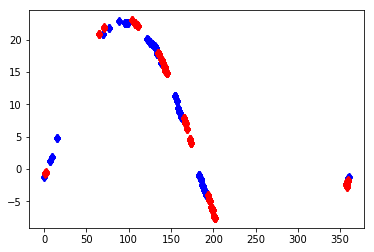

In [104]:
RA = []
DEC = []
RA2 = []
DEC2 = []
get_bar = get_astroquery_function('5','astrometric','f51')
for i in range(0,743):
    RA.append(radecmain[0][i][0][0])
    DEC.append(radecmain[0][i][0][1])
    thor = Time(times[i], format='jd', scale='utc')
    thor = thor.tt.value
    temp = get_bar(thor)    
    RA2.append(temp[2][0])
    DEC2.append(temp[2][1])
    print(i)
plt.plot(RA,DEC,"d",color = "blue")
plt.plot(RA2,DEC2,"d",color = 'red')

There is clearly a timing error with the satellites